### Imports

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from pandas import DatetimeIndex

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math

### Carregamento dos dados

In [2]:
dataOriginal = pd.read_excel('Global_Superstore2.xlsx', index_col=0, comment='#') 
df = dataOriginal 

### Tratamento dos dados

In [3]:
df['Ship Mode'] = df['Ship Mode'].astype('category')
df['Segment'] = df['Segment'].astype('category')
df['City'] = df['Country'].astype('category')
df['State'] = df['Country'].astype('category')
df['Country'] = df['Country'].astype('category')
df['Market'] = df['Market'].astype('category')
df['Region'] = df['Region'].astype('category')
df['Category'] = df['Category'].astype('category')
df['Sub-Category'] = df['Sub-Category'].astype('category')
#df['Orde Priority'] = df['Order Priority'].astype('category')

In [4]:
if df['Profit'].isnull().sum() > 0:
    df = df[df['Profit'].notna()]

In [5]:
# Já está justificado no ficheiro data_exploration o porquê de removermos Códigos postais.
if 'Postal Code' in df.columns:
    df = df.drop('Postal Code', axis=1)
 

df = df.rename(columns = {'Shipping Cost':'Shipping_Cost'})
df = df.rename(columns = {'Order Priority':'Order_Priority'})

#data['Product Name'] = data['Product Name'].mode().iloc[0]
#data.Order_Priority = most_imputer2.fit_transform(data[['Order_Priority']])

print("Total de valores nulos ")
print(df.isnull().sum())

Total de valores nulos 
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
City              0
State             0
Country           0
Market            0
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
Quantity          0
Discount          0
Profit            0
Shipping_Cost     0
Order_Priority    0
dtype: int64


In [6]:
def show_frequencies_categorys():
    for coluna in df.select_dtypes(exclude=["number","bool_", "float64"]).columns:
        #print(coluna)
        if df[coluna].nunique() > 10 and ("Date" not in coluna) and ("ID" not in coluna):

            
            #df2=dfgroupby([coluna])[coluna].sum().rename("Courses_fee").groupby(level = 0).transform(lambda x: x/x.sum())
            coluna_percentagens = (df[coluna].value_counts()/df[coluna].count())*100
           # print(coluna_percentagens)
           # print("Exp:")
            values = coluna_percentagens.groupby(coluna_percentagens > 1).filter(lambda x: x.mean() > 1)
            if values.size > 0:
                print("\n", coluna, "'s com mais de 1% de valores\n")
                print(values)


# Juntar países e cidades cuja frequência é menor que uma especificada, para dados categóricos
# Esses dados são: "State", "City", "Country", "Market", "Region"
percentage = 1

dataset = df
for coluna in ["State", "City", "Country", "Market", "Region" ]:

        #print(coluna)
        series = dataset.value_counts(dataset[coluna])
        mask = (series/series.sum() * 100).lt(percentage)
        #print(mask,"\n\n")
        dataset[coluna] = np.where(dataset[coluna].isin(series[mask].index),'Other',dataset[coluna])

df = dataset

show_frequencies_categorys()


 City 's com mais de 1% de valores

Other                 24.707031
United States         19.343750
Australia              5.541016
France                 5.521484
Mexico                 5.164062
Germany                4.033203
China                  3.671875
United Kingdom         3.189453
Brazil                 3.123047
India                  3.037109
Indonesia              2.714844
Turkey                 2.691406
Italy                  2.164062
Nigeria                1.767578
Spain                  1.677734
Dominican Republic     1.449219
El Salvador            1.437500
Cuba                   1.414062
Honduras               1.392578
Philippines            1.330078
New Zealand            1.226562
Nicaragua              1.199219
Iran                   1.185547
Guatemala              1.017578
Name: City, dtype: float64

 State 's com mais de 1% de valores

Other                 24.707031
United States         19.343750
Australia              5.541016
France                 5.521484
Me

In [7]:
data = df
number_bins = 6

from pandas.api.types import is_numeric_dtype

if is_numeric_dtype(data['Discount']):
    # Bins in discount
   
    min_value = data['Discount'].min()
    
    max_value = data['Discount'].max()
    limits_bins = np.linspace(min_value,max_value , num=number_bins)
    labels_names = []
    for i in range(0, len(limits_bins) - 1):
        v1 = '{:.2f}'.format(limits_bins[i])
        v2 = '{:.2f}'.format(limits_bins[i+1])
        labels_names.append(f'{v1}-{v2}')
    #print("v1: ", limits_bins[i])
    #print("v2: ", limits_bins[i+1])
    #print("----")
#    data4.loc[data4['score'].between(0, 50, 'both'), 'grade'] = 'C'
#print(labels_names)
    data['Discount'] = pd.cut(x = data['Discount'], bins = limits_bins, labels = labels_names, include_lowest = True)
    print(data)
df = data

               Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
Row ID                                                                        
32298    CA-2012-124891  31-07-2012  31-07-2012        Same Day    RH-19495   
26341     IN-2013-77878  05-02-2013  07-02-2013    Second Class    JR-16210   
25330     IN-2013-71249  17-10-2013  18-10-2013     First Class    CR-12730   
13524   ES-2013-1579342  28-01-2013  30-01-2013     First Class    KM-16375   
47221      SG-2013-4320  05-11-2013  06-11-2013        Same Day     RH-9495   
...                 ...         ...         ...             ...         ...   
24175     IN-2014-57662  05-08-2014  10-08-2014  Standard Class    DB-13270   
29002     IN-2014-62366  19-06-2014  19-06-2014        Same Day    KE-16420   
35398    US-2014-102288  20-06-2014  24-06-2014  Standard Class    ZC-21910   
9596     MX-2012-140767  18-02-2012  22-02-2012  Standard Class    RB-19795   
6147     MX-2012-134460  22-05-2012  26-05-2012    S

In [8]:
# Tratar das datas
data2 = df

if "Order Date" in data2:
    consider_year = True
    consider_month = True
    consider_day = True
else: 
    consider_year = False
    consider_month = False
    consider_day = False
    
# Converter datas, acho que já está feito em cima, depois confirmar
dates_order = DatetimeIndex(pd.to_datetime(data2['Order Date'],format='%d-%m-%Y', errors='coerce'))
dates_ship = DatetimeIndex(pd.to_datetime(data2['Ship Date'],format='%d-%m-%Y', errors='coerce'))
if consider_year : 
    data2['Year_order'] = dates_order.year
    data2['Year_ship'] = dates_ship.year
    
if consider_month : 
    data2['Month_order'] = dates_order.month
    data2['Month_ship'] = dates_ship.month

if consider_day : 
    data2['Day_order'] = dates_order.day
    data2['Day_ship'] = dates_ship.day
if 'Order Date' in data2:
    data2 = data2.drop(['Order Date', 'Ship Date'], axis=1)

df = data2

In [9]:
# Label encoding de algumas variáveis
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()

def do_LabelEncoding(dataset, col_name):
    if col_name in dataset:
        dataset[col_name] = lb_make.fit_transform(dataset[col_name])
    return dataset   

if "Category" in data2:
    process_Product_ID = True
    process_Costumer_ID = True
    process_Category = True
    process_Sub_Category = True
    process_Discount = True
else: 
    process_Product_ID = False
    process_Costumer_ID = False
    process_Category = False
    process_Sub_Category = False
    process_Discount = False

for coluna in data2.select_dtypes(exclude=["number","bool_", "float64"]).columns:
    data2 = do_LabelEncoding(data2, coluna)


'''
if process_Product_ID:
    data2["Product ID LabelEnc"] = lb_make.fit_transform(data2["Product ID"])

if process_Costumer_ID:
    data2["Costumer ID LabelEnc"] = lb_make.fit_transform(data2["Customer ID"])

if process_Category:
    data2["Category LabelEnc"] = lb_make.fit_transform(data2["Category"])

if process_Sub_Category:
    data2["Sub-Category LabelEnc"] = lb_make.fit_transform(data2["Sub-Category"])
if process_Discount:
    data2["Discount LabelEnc"] = lb_make.fit_transform(data2["Discount"])

    
if process_Product_ID: 
    data2 = data2.drop(['Product ID', 'Customer ID', "Category", "Sub-Category", "Discount"], axis=1)
#from pandas.api.types import is_string_dtype
'''
if data2['Ship Mode'].dtype == 'category' or data2['Ship Mode'].dtype == 'object':
   # print("Ship mode ainda está em categorias")
    #print(data2['Ship Mode'].unique())
    ship_mode_dic = {'Same Day':1, 'First Class':2, 'Second Class':3,'Standard Class':4}
    #dataTemp = pd.DataFrame({"Ship Mode": ship_mode_dic.keys()})
    #print("Aqui vai\n")
    data2["Ship Mode"]= data2["Ship Mode"].apply(lambda x: ship_mode_dic.get(x))
    #print(data2)

if "Order_Priority" in data2 and (data2['Order_Priority'].dtype == 'category' or data2['Order_Priority'].dtype == 'object'):
    dataTemp = data2
    # print("Ship mode ainda está em categorias")
    #print(dataTemp['Order_Priority'].unique())
    priorities_dic = {'Critical':1, 'High':2, 'Medium':3,'Low':4}
    #dataTemp = pd.DataFrame({"Order_Priority": priorities_dic.keys()})
    #print("Aqui vai\n")
    dataTemp["Order_Priority"]= dataTemp["Order_Priority"].apply(lambda x: priorities_dic.get(x))
    #print(dataTemp.info())
    data2 = dataTemp

 

print("\nApós fazer Label Encoding")
print(data2)



Após fazer Label Encoding
        Order ID  Ship Mode  Customer ID  Customer Name  Segment  City  State  \
Row ID                                                                          
32298       1493          1         1286            632        0    23     23   
26341      13042          2          808            413        1     0      0   
25330      12962          0          336            181        0     0      0   
13524       6792          0          873            424        2     7      7   
47221      21681          1         1290            632        0    18     18   
...          ...        ...          ...            ...      ...   ...    ...   
24175      13967          3          383            217        2     0      0   
29002      14047          1          854            427        1    18     18   
35398      24213          3         1587            793        0    23     23   
9596       17682          3         1249            652        2     1      1   
6

### Neurónios

In [10]:
#dataset_MLP = dataset.drop(columns=['Order ID', 'Customer ID', 'Customer Name', 'Product ID', 'Product Name', 'Postal Code'])
dataset_MLP = data2

#dataset_MLP = dataset_MLP.drop(['Order Priority', 'Market', "City", "Segment", "Ship Mode", "Ship Date"], axis=1)
print(dataset_MLP.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51200 entries, 32298 to 6147
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order ID        51200 non-null  int32  
 1   Ship Mode       51200 non-null  int32  
 2   Customer ID     51200 non-null  int32  
 3   Customer Name   51200 non-null  int32  
 4   Segment         51200 non-null  int32  
 5   City            51200 non-null  int32  
 6   State           51200 non-null  int32  
 7   Country         51200 non-null  int32  
 8   Market          51200 non-null  int32  
 9   Region          51200 non-null  int32  
 10  Product ID      51200 non-null  int32  
 11  Category        51200 non-null  int32  
 12  Sub-Category    51200 non-null  int32  
 13  Product Name    51200 non-null  int32  
 14  Sales           51200 non-null  float64
 15  Quantity        51200 non-null  float64
 16  Discount        51200 non-null  int32  
 17  Profit          51200 non-nu

In [11]:
import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

RANDOM_SEED = 2021

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.10.0


In [12]:
X_MLP = dataset_MLP.drop('Profit', axis=1)
y_MLP = dataset_MLP[['Profit']]


# Convert data
if "Order Date" in X_MLP:
    consider_year = True
    consider_month = True
    consider_day = True
else: 
    consider_year = False
    consider_month = False
    consider_day = False
'''   
# Converter datas 
dates_order = DatetimeIndex(pd.to_datetime(X_MLP['Order Date'],format='%d-%m-%Y', errors='coerce'))
if consider_year : 
    X_MLP['Year_order'] = dates_order.year
    
if consider_month : 
    X_MLP['Month_order'] = dates_order.month
    
if consider_day : 
    X_MLP['Day_order'] = dates_order.day
    
if 'Order Date' in X_MLP:
    X_MLP = X_MLP.drop(['Order Date'], axis=1)
#print(X)
# Convert ID's to Label encoding
from sklearn.preprocessing import LabelEncoder

if "State" in X_MLP:
    list_to_process = ["State", "Country", "Region", "Category", "Sub-Category"]

lb_make = LabelEncoder()

if list_to_process:
    for column in list_to_process:
        X_MLP[column] = lb_make.fit_transform(X_MLP[column]) 
'''


scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(X_MLP)

scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(y_MLP)

X_scaled = pd.DataFrame(scaler_X.transform(X_MLP[X_MLP.columns]), columns=X_MLP.columns)
y_scaled = pd.DataFrame(scaler_y.transform(y_MLP[y_MLP.columns]), columns=y_MLP.columns)

In [13]:
X_scaled=X_scaled.dropna().reset_index(drop=True)
y_scaled=y_scaled.dropna().reset_index(drop=True)



X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=RANDOM_SEED)

number_columns = len(X_scaled.columns)#.count()
#print("Número de colunas: ", number_columns)

def build_model(activation='relu', learning_rate=0.01):
#create a sequential model (with three Layers - Last one is the output)
    model = Sequential()
    model.add(Dense(number_columns, input_dim=number_columns, activation=activation))
    model.add(Dense(6, activation=activation))
    model.add(Dense(1, activation='relu'))
  
     #compile the model
    #Define the Loss function, the otimizer and metrics to be used
    model. compile(
        loss = 'mae',
        optimizer = tf.optimizers.Adam(learning_rate),
        metrics = ['mae', 'mse'])
    return model

model = build_model()
model.summary()
''' Este é melhor, mas mais lento
TUNING_DICT = {
    'activation' : ['relu', 'sigmoid'],
    'learning_rate' : [0.01, 0.001]
}
'''
TUNING_DICT = {
    'activation' : ['relu'],
    'learning_rate' : [0.01]
}
kf = KFold(n_splits=2, shuffle=True, random_state=RANDOM_SEED)

model = KerasRegressor(build_fn=build_model, epochs=15,batch_size=number_columns)
grid_search = GridSearchCV(estimator = model,
                            param_grid = TUNING_DICT,
                            cv = kf,
                            scoring = 'neg_mean_absolute_error',
                            refit ='True',
                            verbose = 1)

grid_search.fit(X_train, y_train, validation_split=0.2)

"""
def BuildModel():
     model = Sequential()
     model.add(Dense(128, input_dim=12,activation='relu')) 
     model.add(Dense(32, activation='relu')) 
     model.add(Dense(8,activation='relu')) 
     model.add(Dense(1,activation='linear'))
     model.compile(loss="mean_squared_error", optimizer="adam")   
     return model

BuildModel().summary()

regressor = KerasRegressor(build_fn=BuildModel,epochs=20,batch_size=12)
print(X_scaled)
print(y_scaled)
regressor.fit(X_scaled,y_scaled) 

y_pred = regressor.predict(X_scaled)
 

mse_krr = mean_squared_error(y_scaled, y_pred)

"""

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                650       
                                                                 
 dense_1 (Dense)             (None, 6)                 156       
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 813
Trainable params: 813
Non-trainable params: 0
_________________________________________________________________
Fitting 2 folds for each of 1 candidates, totalling 2 fits


C:\Users\Diogo\AppData\Local\Temp\ipykernel_6704\1883372435.py:40: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model, epochs=15,batch_size=number_columns)


Epoch 1/15
656/656 [==============================] - 4s 4ms/step - loss: 0.0139 - mae: 0.0139 - mse: 0.0010 - val_loss: 0.0052 - val_mae: 0.0052 - val_mse: 7.6704e-05
Epoch 2/15
656/656 [==============================] - 2s 3ms/step - loss: 0.0049 - mae: 0.0049 - mse: 1.2335e-04 - val_loss: 0.0033 - val_mae: 0.0033 - val_mse: 6.6487e-05
Epoch 3/15
656/656 [==============================] - 2s 3ms/step - loss: 0.0041 - mae: 0.0041 - mse: 1.1816e-04 - val_loss: 0.0036 - val_mae: 0.0036 - val_mse: 6.8089e-05
Epoch 4/15
656/656 [==============================] - 2s 4ms/step - loss: 0.0040 - mae: 0.0040 - mse: 1.1689e-04 - val_loss: 0.0057 - val_mae: 0.0057 - val_mse: 8.4270e-05
Epoch 5/15
656/656 [==============================] - 2s 3ms/step - loss: 0.0040 - mae: 0.0040 - mse: 1.1701e-04 - val_loss: 0.0033 - val_mae: 0.0033 - val_mse: 6.7062e-05
Epoch 6/15
656/656 [==============================] - 2s 3ms/step - loss: 0.0039 - mae: 0.0039 - mse: 1.1604e-04 - val_loss: 0.0042 - val_mae: 0

'\ndef BuildModel():\n     model = Sequential()\n     model.add(Dense(128, input_dim=12,activation=\'relu\')) \n     model.add(Dense(32, activation=\'relu\')) \n     model.add(Dense(8,activation=\'relu\')) \n     model.add(Dense(1,activation=\'linear\'))\n     model.compile(loss="mean_squared_error", optimizer="adam")   \n     return model\n\nBuildModel().summary()\n\nregressor = KerasRegressor(build_fn=BuildModel,epochs=20,batch_size=12)\nprint(X_scaled)\nprint(y_scaled)\nregressor.fit(X_scaled,y_scaled) \n\ny_pred = regressor.predict(X_scaled)\n \n\nmse_krr = mean_squared_error(y_scaled, y_pred)\n\n'

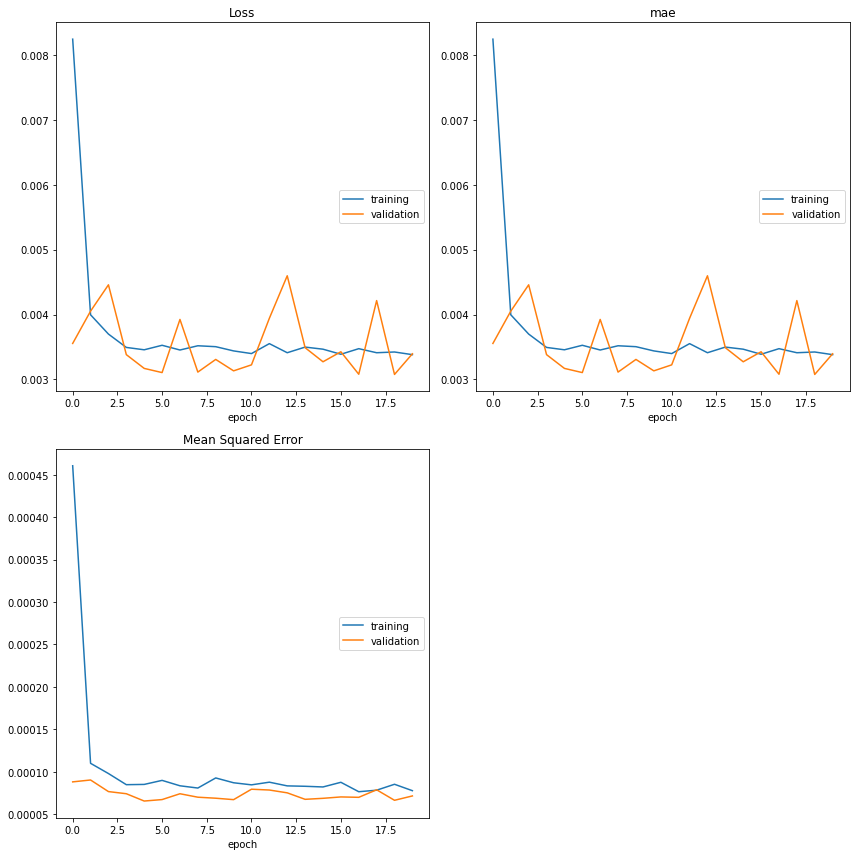

Loss
	training         	 (min:    0.003, max:    0.008, cur:    0.003)
	validation       	 (min:    0.003, max:    0.005, cur:    0.003)
mae
	training         	 (min:    0.003, max:    0.008, cur:    0.003)
	validation       	 (min:    0.003, max:    0.005, cur:    0.003)
Mean Squared Error
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
1639/1639 [==============================] - 5s 3ms/step - loss: 0.0034 - mae: 0.0034 - mse: 7.7639e-05 - val_loss: 0.0034 - val_mae: 0.0034 - val_mse: 7.1438e-05


In [14]:
# Overfitting analisys

#Our best model (remember we set refit
best_mlp_model = grid_search.best_estimator_

from livelossplot import PlotLossesKerasTF
best_mlp_model.fit(X_train, y_train, epochs=20,
validation_data=(X_test, y_test),
callbacks=[PlotLossesKerasTF()], verbose=1)

### Análise de overfitting

Pelos gráficos, vemos que o medium average error (mae) dá bastante mal, mas o mse dá bem. Como 20 epochs é um valor considerável, consideramos nesta fase melhorar o tratamento de dados, e depois verificar se há melhorias. 
Isto porque, o tratamento de dados atual para este modelo é quase com o objetivo de o modelo consiguir analisar o dataset.

In [15]:
 #0btain predictions

predictions = best_mlp_model.predict(X_test)

predictions = predictions.reshape(predictions.shape[0], 1)
predicions_unscaled = scaler_y.inverse_transform(predictions)
predicions_unscaled[:5]

410/410 [==============================] - 1s 2ms/step


array([[49.516495],
       [31.58464 ],
       [29.589529],
       [29.589529],
       [29.589529]], dtype=float32)

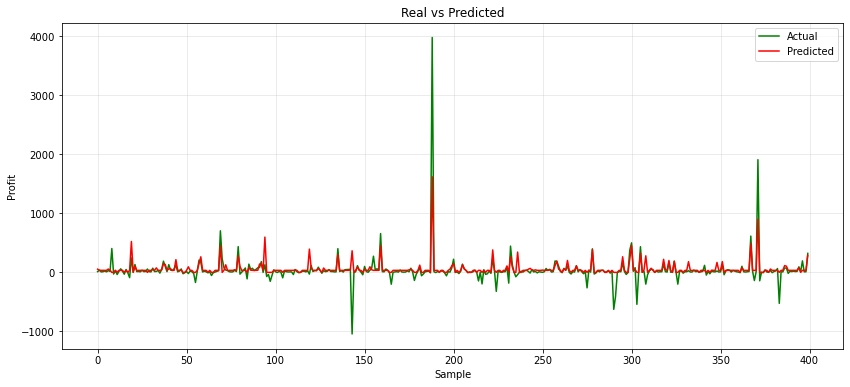

In [16]:
y_test_unscaled = scaler_y.inverse_transform(y_test)

#Visualising the actual and predicted result
def real_predicted_viz(limit):
    plt.figure(figsize=(14,6))
    plt.plot(y_test_unscaled[:limit], color = 'green', label = 'Actual')
    plt.plot (predicions_unscaled[:limit], color = 'red', label = 'Predicted')
    plt.grid(alpha = 0.3)
    plt.xlabel('Sample')
    plt.ylabel ('Profit')
    plt.title('Real vs Predicted')
    plt.legend()
    plt.show()

#let's Limit to 200 comparisions for better visualization
real_predicted_viz(400)


Pela análise do gráfico, podemos ver que há algumas previsões aproximadamente corretas, mas existem algumas, bem visíveis, que mostram quão errado o nosso modelo está.
Como dito anteriormente, falta tratamento de dados. 

In [17]:

print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Média: %f Desvio padrão: (%f) com: %r" % (mean, stdev, param))


Best: -0.003465 using {'activation': 'relu', 'learning_rate': 0.01}
Média: -0.003465 Desvio padrão: (0.000130) com: {'activation': 'relu', 'learning_rate': 0.01}


In [29]:
#tf.keras.losses.mean_absolute_error(y_test_unscaled, predicions_unscaled)
mae = tf.keras.losses.MeanAbsoluteError()
print("MAE: ", mae(y_test_unscaled, predicions_unscaled).numpy())
#mse = tf.keras.losses.mean_squared_error(y_test_unscaled, predicions_unscaled).numpy()
mse = np.mean(np.square(y_test_unscaled - predicions_unscaled))
print("MSE: ", mse)
print("RMSE: ", math.sqrt(mse))

MAE:  50.92382
MSE:  16073.502116337302
RMSE:  126.78131611691568
